 - Look at the different configurations of pre-trained BERT model open source by Google
 - Learn how to use pre-trained BERT model as a feature extractor
 - Explore Hugging Face's transformers library
 - Learn how to fine-tune the pre-trained model BERT model for the downstream tasks.



Some notes:

- pre-trained models are also available in the BERT-uncased and BERT-cased formats.

  -If we were doing the task of NER where we have to preserve the case, the BERT-cased format would be more favorable.

**How can we use the pre-trained model?**

We can use the model:
- As a feature extractor by extracing embeddings
- By fine-tuning the pre-trained BERT model on downstream tasks such as text classification, question-answering, and more.

# 1. Use pre-trained BERT model as a feature (embeddings) extractor.

**In this section, we will learn how to etract word-level and sentence-level embedding from pre-trained BERT model**
(Using pre-trained BERT model to vectorize the sentences)

To be clearer, the embeddings we're taking about are contextual embedding instead of normal embeddings from Word2Vec.

- The contextualized word (token) embeddings are also knowned as representations output by the pre-trained BERT.

- In the encoder side of BERT, we added [CLS] token at the start of our sentence. This [CLS]'s embedding will **hold the aggregate representation of the complete sentence**

--> So, the representation of our whole sentence is **just the embedding (or representation) of the [CLS] token.**

- Once we have the sentence representation of all the sentences in our dataset, we can feed those representations as input and train a classifier to perform sentiment analysis tasks.

**Note:** we can also average or pool the representation of all the tokens to obtain the representation of the sentence.

## Hugging Face transformer

Hugging Face is an organization that is on the path of democratizing AI through natural language. 

Their open source transformers library is very popular among the Natural Language Processing (NLP) community. It is very useful and powerful for several NLP and Natural Language Understanding (NLU) tasks. 

It includes thousands of pre-trained models in **more than 100 languages**. One of the many advantages of the transformer's library is that it is compatible with both PyTorch and TensorFlow.

In [2]:
!pip install transformers
!pip install nlp

     |████████████████████████████████| 2.6 MB 8.9 MB/s 
     |████████████████████████████████| 895 kB 43.8 MB/s 
     |████████████████████████████████| 3.3 MB 44.7 MB/s 
     |████████████████████████████████| 636 kB 44.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.7 MB 8.0 MB/s 
     |████████████████████████████████| 243 kB 42.3 MB/s 


In [3]:
from transformers import BertModel, BertTokenizer
import torch

Let's download the pre-trained BERT model

In [4]:
# bert-base-uncased model

model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


As the name suggested, this model will have 12 encoders and is trained with uncased tokens.

And the BERT-base, the representation size will be 768.

In [5]:
#Download the tokenizer that was used to pre-train the bert-based-uncased model

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Let's make an example

In [6]:
sentence = 'I love Paris'

tokens  = tokenizer.tokenize(sentence)

print(tokens)

['i', 'love', 'paris']


Now we will add [CLS] and [SEP] tokens at the start and the end of the tokens list respectively:

In [7]:
tokens = ['[CLS]'] + tokens + ['[SEP]']

print(tokens)

['[CLS]', 'i', 'love', 'paris', '[SEP]']


Say we need to keep the length of our tokens list to 7, we add two [PAD] tokens at the end:

In [8]:
tokens = tokens + ['[PAD]'] + ['[PAD]']

print(tokens)

['[CLS]', 'i', 'love', 'paris', '[SEP]', '[PAD]', '[PAD]']


Now, let's create attention_mask, basically, any token which is not a [PAD] token will be masked as 1, otherwise it will be masked as 0.

In [9]:
attention_mask = [1 if i != '[PAD]' else 0 for i in tokens]

print(attention_mask)

[1, 1, 1, 1, 1, 0, 0]


Next, we conver all the tokens to their token IDs as follow:
basically, each token will be assigned a unique ID.

In [10]:
seg_ids=[0 for _ in range(len(tokens))]
print("Segment Tokens are \n {}".format(seg_ids))

Segment Tokens are 
 [0, 0, 0, 0, 0, 0, 0]


In [11]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(token_ids)

[101, 1045, 2293, 3000, 102, 0, 0]


Now, we convert token_ids and attention_mask to tensors

In [12]:
token_ids = torch.tensor(token_ids).unsqueeze(0)

attention_mask = torch.tensor(attention_mask).unsqueeze(0)

seg_ids = torch.tensor(seg_ids).unsqueeze(0)



In [13]:
print(token_ids)

tensor([[ 101, 1045, 2293, 3000,  102,    0,    0]])


### Getting the embeddings from the last encoder (12th encoder)

When we feed the token_ids and attention_mask tensors to the mode, it will output a tuple containing 2 values:

- hidden_rep: consists of the representations of all tokens obtained from the final encoder (12th encoder)

- cls_head: representation of the [CLS] token

In [14]:
hidden_rep, cls_head = model(token_ids, attention_mask = attention_mask,return_dict=False)

In [15]:
print(hidden_rep.shape)

torch.Size([1, 7, 768])


[1,7,768] indicates [batch_size,sequence_length, hidden_size]

- 1: 1 sentence processed
- 7: 7 tokens
- 768: embedding size of the BERT-base model

In [16]:
hidden_rep

tensor([[[-0.0719,  0.2163,  0.0047,  ..., -0.5865,  0.2262,  0.1981],
         [ 0.2236,  0.6536, -0.2294,  ..., -0.3547,  0.5517, -0.2367],
         [ 1.0410,  0.7755,  1.0335,  ..., -0.5621,  0.5218, -0.0852],
         ...,
         [ 0.6156,  0.1036, -0.1875,  ..., -0.3799, -0.7008, -0.3500],
         [ 0.0791,  0.4287,  0.4147,  ..., -0.2417,  0.2403,  0.0378],
         [-0.0165,  0.2459,  0.4566,  ..., -0.2179,  0.1876,  0.0228]]],
       grad_fn=<NativeLayerNormBackward>)

In [17]:
#representation of the [CLS] token
cls_head.shape

torch.Size([1, 768])

We can also extract the representations of the other tokens of the sentence from the hidden_state:

- R[ClS]: hidden_rep[0][0]
- R[I]: hidden_rep[0][1]


In [18]:
hidden_rep[0][0].shape

torch.Size([768])

We can use the R[CLS] as the representation of the whole sentence as it holds the aggregate representation of the sentence.

### Extracting the embeddings from all encoder layers

In [19]:
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
# Preprocess the input

sentence = 'I love Paris'

tokens = tokenizer.tokenize(sentence)

tokens = ['[CLS]'] + tokens + ['[SEP]']

print(tokens)

['[CLS]', 'i', 'love', 'paris', '[SEP]']


In [21]:
#add pad tokens

tokens = tokens + ['[PAD]'] + ['[PAD]']

#create attention_mask

attention_mask = [1 if i != '[PAD]' else 0 for i in tokens]

In [22]:
#conver the tokens to token IDs:
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(token_ids)

[101, 1045, 2293, 3000, 102, 0, 0]


In [23]:
#conver token_ids and attention_mask to tensors

token_ids = torch.tensor(token_ids).unsqueeze(0)

attention_mask = torch.tensor(attention_mask).unsqueeze(0)

Let's get the embeddings

In [24]:
last_hidden_state, pooler_output, hidden_states = model(token_ids, attention_mask, return_dict = False)

- **last_hidden_state**: contains the representation of all the tokens obtained only from the final encoder layer

- **pooler_output**: representation of the [CLS] token from the final encoder layer

- **hidden_states**: contains the representation of all tokens from all the encoder layers

In [25]:
last_hidden_state.shape

torch.Size([1, 7, 768])

In [26]:
pooler_output.shape

torch.Size([1, 768])

In [27]:
len(hidden_states)

13

13 = 1 + 12:

- hidden_states[0]: input layer's embeddings
- hidden_states[1]: representation from the first encoder layer

and so forth

# 2. Fine-tuning BERT for downstream tasks

Typical downstream tasks: 
- Text classification
- Natural language inference
- NER
- Question-answering

We will feed the R[CLS] to a classifier (a feed-forward network with softmax function) and train the classifier to perform sentiment analysis

- **Fine-tuning the BERT**: update the weights of the pre-trained BERT model along with the classifier

- **Use pre-trained BERT model as feature extractor**: we don't update the weights of the BERT model but the classifier only.

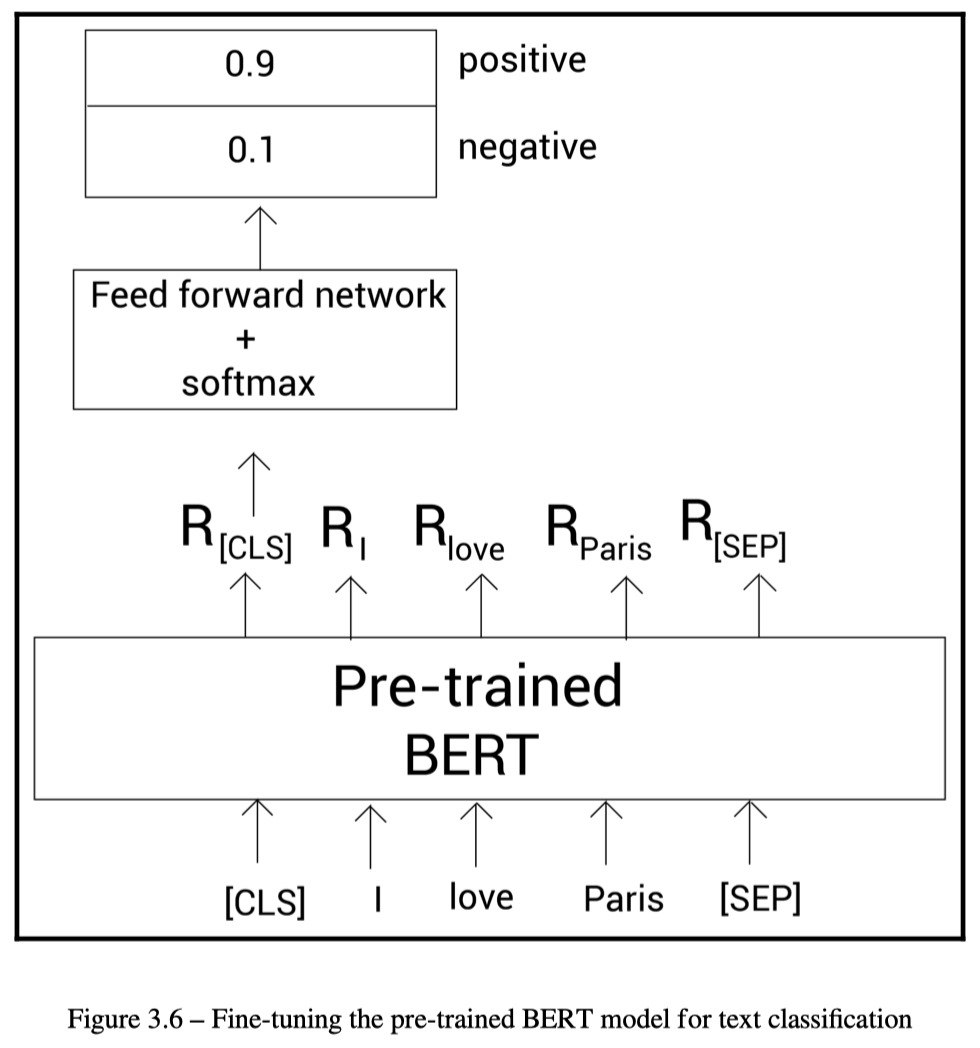

## 2.1. Fine-tuning BERT for sentiment analysis

We will do this sentiment analysis with the IMDB datset, which consists of movie reviews along with the respective sentiment of the review.

### 2.1.1. Import packages and collect data

In [28]:
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
from nlp import load_dataset
import numpy as np


In [29]:
!gdown https://drive.google.com/uc?id=11_M4ootuT7I1G0RlihcC0cA3Elqotlc-

dataset = load_dataset('csv', data_files='./imdbs.csv', split='train')

Downloading...
From: https://drive.google.com/uc?id=11_M4ootuT7I1G0RlihcC0cA3Elqotlc-
To: /content/imdbs.csv
100% 132k/132k [00:00<00:00, 29.4MB/s]


Using custom data configuration default


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-11046c2826f07a01/0.0.0/ede98314803c971fef04bcee45d660c62f3332e8a74491e0b876106f3d99bd9b. Subsequent calls will reuse this data.


In [30]:
type(dataset)

nlp.arrow_dataset.Dataset

In [31]:
dataset = dataset.train_test_split(test_size=0.3)

In [32]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}, num_rows: 30),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}, num_rows: 70)}

In [33]:
train_set = dataset['train']
test_set = dataset['test']

### 2.1.2. Load pre-trained BERT model

In [34]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### 2.1.3. Preprocess the data

In [35]:
def preprocess(data):
  return tokenizer(data['text'],padding = True,truncation= True)

In [36]:
#preprocess the train and test sets using the preprocess function

train_set = train_set.map(preprocess, batched=True, batch_size = len(train_set))

test_set = test_set.map(preprocess, batched = True, batch_size = len(test_set))

In [37]:
train_set

Dataset(features: {'label': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 70)

let's print out some sentences that have been tokenized

In [38]:
for i in range(5):
  print(train_set['input_ids'][i])

[101, 2061, 2292, 1005, 1055, 4088, 999, 1007, 1007, 1007, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 3185, 2993, 2003, 2004, 2434, 2004, 13675, 5643, 11144, 1005, 1055, 5691, 2052, 2788, 3711, 1012, 1012, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 2026, 6808, 2000, 2156, 2009, 2001, 5121, 29017, 2140, 2108, 2028, 1997, 2026, 8837, 19910, 1012, 2016, 2003, 2004, 8403, 2004, 5156, 1010, 2023, 3013, 2666, 999, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1045, 2052, 2025, 2360, 2009, 2001, 2026, 8837, 3185, 1997, 5106, 1012, 2145, 2009, 1005, 1055, 3243, 5875, 1998, 14036, 2000, 3582, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 2717, 1997, 1996, 3459, 2003, 2025, 5186, 8052, 2021, 2009, 2003, 2025, 2070, 2785, 1997, 1037, 28616, 10526, 2732, 9140, 1012, 1025, 1007, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 16755, 2007, 7023, 999, 1007, 1007, 1007, 1007, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [39]:
# We use set_format function to select the columns that we need in out dataset

train_set.set_format('torch', columns = ['input_ids','attention_mask','label'])

test_set.set_format('torch', columns = ['input_ids','attention_mask','label'])

In [40]:
train_set

Dataset(features: {'label': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 70)

### 2.1.4. Training the model

In [41]:
batch_size = 8

epochs = 2

In [42]:
warmup_steps = 500

weight_decay = 0.01

In [43]:
#Define the training arguments

training_args =TrainingArguments(output_dir='./results', 
                                 num_train_epochs=epochs, 
                                 per_device_train_batch_size=batch_size, 
                                 per_device_eval_batch_size=batch_size, 
                                 warmup_steps=warmup_steps, 
                                 weight_decay=weight_decay, 
                                #  evaluate_during_training=True, 
                                 evaluation_strategy='epoch',
                                 logging_dir='./logs',

)

In [44]:
#define the trainer

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_set,
    eval_dataset = test_set
)

In [45]:
#Train the model
trainer.train()

***** Running training *****
  Num examples = 70
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Epoch,Training Loss,Validation Loss
1,No log,0.701275
2,No log,0.691554


***** Running Evaluation *****
  Num examples = 30
  Batch size = 8
***** Running Evaluation *****
  Num examples = 30
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=18, training_loss=0.6921616660224067, metrics={'train_runtime': 9.8776, 'train_samples_per_second': 14.173, 'train_steps_per_second': 1.822, 'total_flos': 36835547750400.0, 'train_loss': 0.6921616660224067, 'epoch': 2.0})

In [46]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 30
  Batch size = 8


{'epoch': 2.0,
 'eval_loss': 0.6915538907051086,
 'eval_runtime': 0.5887,
 'eval_samples_per_second': 50.961,
 'eval_steps_per_second': 6.795}

## 2.2. Natural language inference (NLI)

In NLI, the goal of our model is to determine whether a hypothesis is an entailment (True), a contradiction (false), or undetermined (neutral) given a premise.

Examples:

- premise: he is playing, hypothesis: he is sleeping --> label: contradiction

How can we do it?

- First, we tokenize the sentence pair, then add [CLS] at the beginning of the first senten, 2 [SEP] tokens at the end of each sentence.

- Next, we feed the tokens to the pre-trained BERT model and get the embedding of each token.


- From that, we obtain the representation (embedding) of the [CLS] token, we can take this R[CLS] and feed it to our classifier, which returns the probabilities of sentence being a contradiction, an entailment, or neutral. 

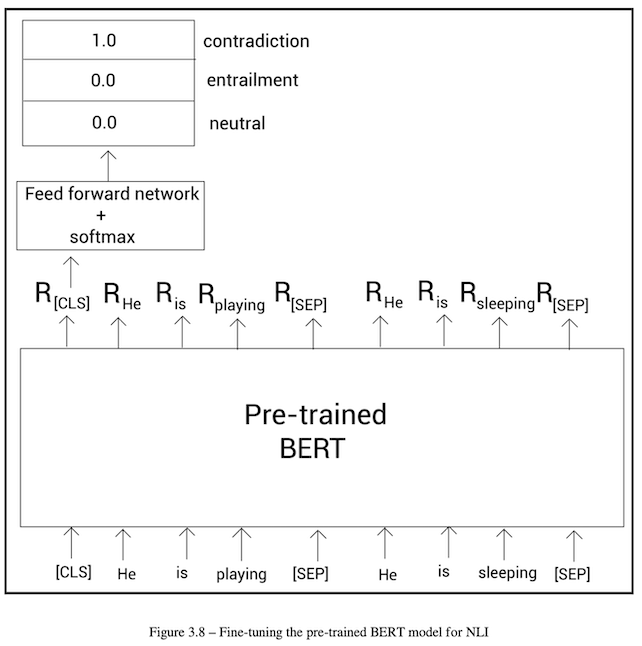

## 2.3. Question - Answering

In the QnA task, we are given a question along with a paragraph containing an answer to the question.

Our goal is to extract the answer from the paragraph for the given question.

So basically, the input for our pre-trained BERT model will be a question-paragraph pair, and it has to extract the answer from that paragraph.

Consider this question-paragraph pair:

- Question: 'What is the immune system?"

- Paragraph: 'The immune system is a system of many biological structures and processes within an organism that protects against disease. To function properly, an immune system must detect a wide variety of agents, known as pathogens, from viruses to parasitic worms, and distinguish them from the organism's own healthy tissue.'

From that pair, our model should extract the following:

- Answer: "a system of many biological structures and processes within an organism that protects against disease"

In order to output that answer, our model has to understand that the answer to this question starts from index 4 ('a') and ends at index 21 ('disease').

So, how to we find the starting and ending index of the text span containing the answer?

-> identify the **probability of each word in the paragraph of being starting and ending token of the answer** --> then we can easily extract the answer.

We can implement the concepts of **vector S** (start vector) and **vector E** (end vector) to achieve the starting token and ending token.

To compute this probability, for each token i in the paragraph, we compute the dot product between the R[i] and the vector S.

Then we apply the softmax function to that product and obtain the probability of being the starting token.

Then we compute the starting index by selecting the index of the token that has the highest prob of being the starting token

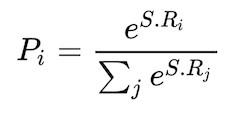

Then we do the same as previous step to identify the ending token.

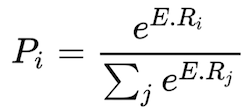

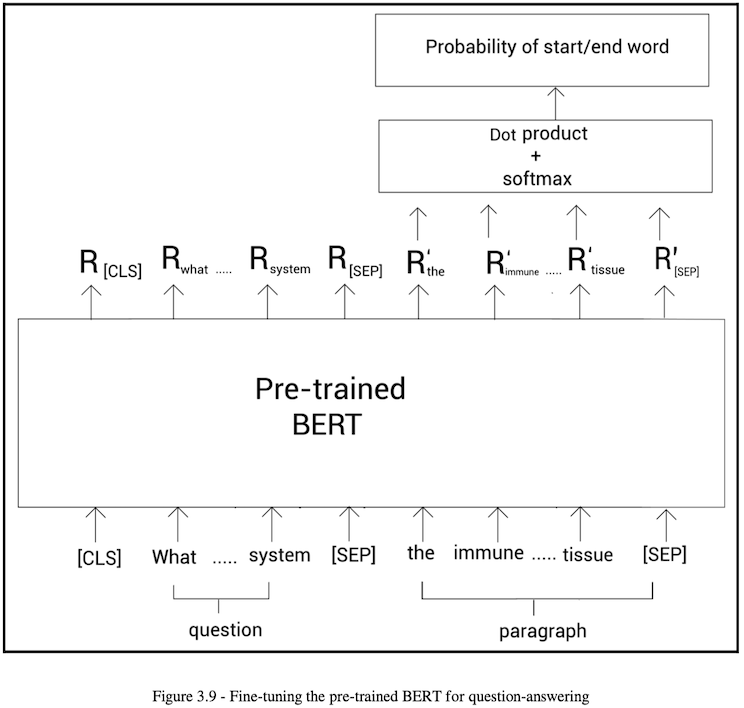

**Let's perform the question-answering with fine-tuned BERT**

In [47]:
from transformers import BertForQuestionAnswering, BertTokenizer

We use the bert-large-uncased-whole-wordmasking-fine-tuned-squad model, which is fine-tuned on the Stanford QuestionAnswering Dataset (SQUAD):

In [48]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp3vgvm933


storing https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
creating metadata file for /root/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob"

https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpl36q13dn


storing https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/28a060c1e2e1216bd9c8f5222ce38ce916c4829b8b05e027fe91510f3fd4da7e.50fc4a146342b3a6a99b185af3d5b70163b64d45790be64d9124dcccbcd3915e
creating metadata file for /root/.cache/huggingface/transformers/28a060c1e2e1216bd9c8f5222ce38ce916c4829b8b05e027fe91510f3fd4da7e.50fc4a146342b3a6a99b185af3d5b70163b64d45790be64d9124dcccbcd3915e
loading weights file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/28a060c1e2e1216bd9c8f5222ce38ce916c4829b8b05e027fe91510f3fd4da7e.50fc4a146342b3a6a99b185af3d5b70163b64d45790be64d9124dcccbcd3915e


All model checkpoint weights were used when initializing BertForQuestionAnswering.

All the weights of BertForQuestionAnswering were initialized from the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForQuestionAnswering for predictions without further training.


In [49]:
#load the tokenizer of the model

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp0cm5m18w


storing https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/68e5260dea718cdc2daf27dc106fd8741636b03e3173b5492e57a7fa525ca33b.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/68e5260dea718cdc2daf27dc106fd8741636b03e3173b5492e57a7fa525ca33b.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99


https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp5fkwj6nm


storing https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/b9f8d92aa5a32cfe504c3524c173dc611dbe81d49392f40601286b94ee1e1169.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /root/.cache/huggingface/transformers/b9f8d92aa5a32cfe504c3524c173dc611dbe81d49392f40601286b94ee1e1169.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79


https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpzpkypavy


storing https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/9b7535fe1c0da28aa7cc66b7f34529d984f535c401be8352f6adeb25f7870def.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
creating metadata file for /root/.cache/huggingface/transformers/9b7535fe1c0da28aa7cc66b7f34529d984f535c401be8352f6adeb25f7870def.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/68e5260dea718cdc2daf27dc106fd8741636b03e3173b5492e57a7fa525ca33b.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-large-uncased-whole-word-masking-fin

loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



### 2.3.1. Preprocess the input

In [50]:
question = 'What is the immune system?'

paragraph = "The immune system is a system of many biological structures and processes within an organism that protects against disease. To function properly, an immune system must detect a wide variety of agents, known as pathogens, from viruses to parasitic worms, and distinguish them from the organism's own healthy tissue."

In [51]:
# Let's tokenize our question and paragraph

question = '[CLS] ' + question + ' [SEP]'

paragraph = paragraph + ' [SEP]'


question_tokens = tokenizer.tokenize(question)

paragraph_tokens = tokenizer.tokenize(paragraph)

In [ ]:
paragraph_tokens

Then we combine the question and paragraph tokens and convert them to input_ids:

In [53]:
tokens = question_tokens + paragraph_tokens
input_ids = tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
input_ids

Now we will define the segment ids, segment_ids will be 0 for all the tokens of the question and 1 for all the tokens of the paragraph

In [56]:
segment_ids = [0] * len(question_tokens)

segment_ids = segment_ids + [1] * len(paragraph_tokens)

In [57]:
len(input_ids)

67

In [58]:
len(segment_ids)

67

In [59]:
#Now we convert input_ids and segment_ids to tensors:

input_ids = torch.tensor([input_ids])

segment_ids = torch.tensor([segment_ids])

### 2.3.2. Let's get the answers

In [62]:
start_scores, end_scores = model(input_ids, token_type_ids = segment_ids, return_dict = False)

In [63]:
start_index = torch.argmax(start_scores)

end_index = torch.argmax(end_scores)

In [64]:
print(' '.join(tokens[start_index:end_index+1]))

a system of many biological structures and processes within an organism that protects against disease


## 2.4. Named entity recognition (NER)

In NER, our goal is to classify named entities into predefined categories.

Consider this sentence: "Jeremy lives in Paris", "Jeremy" should be categorized as a person, and "Paris" should be categorized as a location.

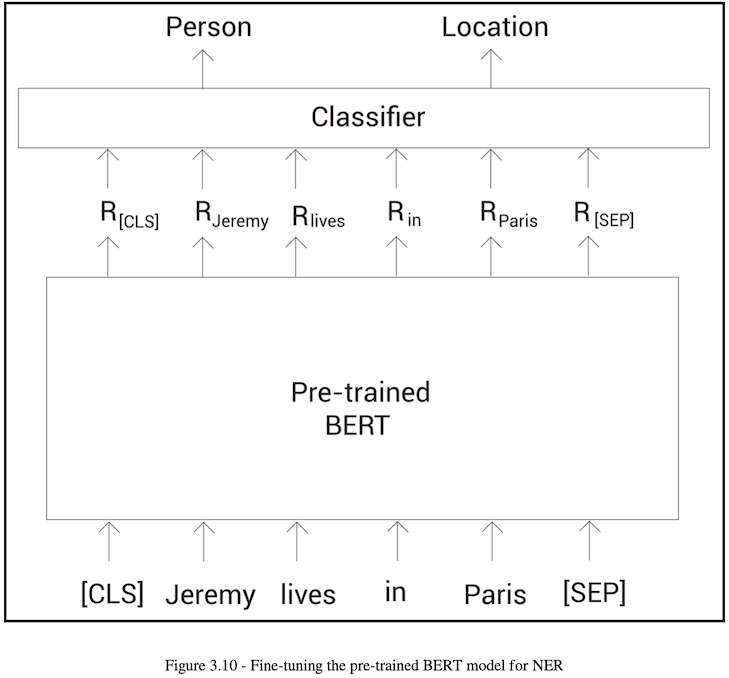